<a href="https://colab.research.google.com/github/sachinomdubey/PRML_Project/blob/main/Codes/Part%201/Handwritten_character_recognition_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################## PRML PROJECT ##########################################
# Title   : Handwritten Character Recognition using NNs (Part-1)
# Team    : Anuradha Uggi (EE21RESCH01008), Sachinkumar Dubey (EE20MTECH11009)
# Course  : PRML
#
# Details : In this project, Permorfance of MLPs and CNNs are analysed and
#           compared in the application of recognition of handwritten characters.
#
#           This is the part-1 program which uses MLPs and analyses its 
#           performance and effect of varying various parameters of the network.
#           For CNN implementation, please refer part-2 program.
################################################################################

In [ ]:
# Importing the required libraries:

import numpy as np
from random import randint
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#from sklearn.pipeline import Pipeline
#from keras.callbacks import CSVLogger
import pandas as pd
import cv2 as cv
#from keras.optimizers import SGD
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [ ]:
# The dataset is uploaded to the following path in the personal google drive (/content/drive/MyDrive/PRML/Project/MNIST_data/gzip/)
# Thus, Mounting the google drive to access the same for training of the network

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing the 'idx2numpy' Library which is required to read the dataset present in an idx file into a numpy array
% pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7918 sha256=419318b04195ef326039cf94905c47ad1feb218ef6f3aef4b373b8a3bfd5cdb1
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


In [ ]:
# Importing the installed 'idx2numpy' library
import idx2numpy

## Importing the dataset present in the drive into a numpy array
# Importing the 112800 training images (28x28)
TrainImages = idx2numpy.convert_from_file('/content/drive/MyDrive/PRML/Project/MNIST_data/gzip/emnist-balanced-train-images-idx3-ubyte') 
# Importing the 112800 training labels
TrainLabels = idx2numpy.convert_from_file('/content/drive/MyDrive/PRML/Project/MNIST_data/gzip/emnist-balanced-train-labels-idx1-ubyte')
# Importing the 18800 testing images (28x28)
TestImages = idx2numpy.convert_from_file('/content/drive/MyDrive/PRML/Project/MNIST_data/gzip/emnist-balanced-test-images-idx3-ubyte')
# Importing the 18800 testing Labels
TestLabels = idx2numpy.convert_from_file('/content/drive/MyDrive/PRML/Project/MNIST_data/gzip/emnist-balanced-test-labels-idx1-ubyte')

# Printing the shapes for imported dataset
print("Training images shape : ", TrainImages.shape)
print("Training labels shape : ", TrainLabels.shape)
print("Testing images shape  : ", TestImages.shape)
print("Testing labels shape  : ", TestLabels.shape)

Training images shape :  (112800, 28, 28)
Training labels shape :  (112800,)
Testing images shape  :  (18800, 28, 28)
Testing labels shape  :  (18800,)


In [ ]:
#Flipping and rotating the images in Train/Test set as the images are not in proper orientation.
TrainImages = TrainImages[:,::-1,:]
TrainImages = TrainImages.swapaxes(-2,-1)[...,::-1]
TestImages = TestImages[:,::-1,:]
TestImages = TestImages.swapaxes(-2,-1)[...,::-1]

In [ ]:
#Function to convert numeric labels (0 to 46) to readable labels (0-9, A-Z, a,b,d,e,f,g,h,n,q,r,t):
def ReadableLabels(arr):
  NumtoChar = {} # Initiating blank python dictionary for mapping from numeric labels to readable labels.
  # Updating the dictionary with the required mappings.
  for i in range(10):
    NumtoChar.update({i:str(i)})
  for i in range(10,36):
    NumtoChar.update({i:chr(55+i)})
  NumtoChar.update({36:'a'})  
  NumtoChar.update({37:'b'})  
  NumtoChar.update({38:'d'})  
  NumtoChar.update({39:'e'})  
  NumtoChar.update({40:'f'})  
  NumtoChar.update({41:'g'})  
  NumtoChar.update({42:'h'})  
  NumtoChar.update({43:'n'})  
  NumtoChar.update({44:'q'})  
  NumtoChar.update({45:'r'})  
  NumtoChar.update({46:'t'})  
  return np.vectorize(NumtoChar.get)(arr)

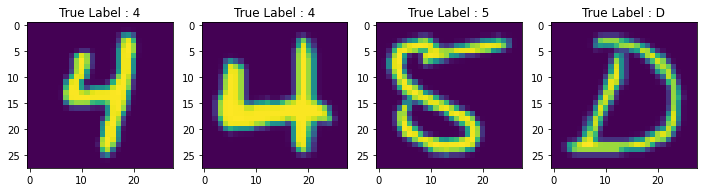

In [ ]:
# Displaying 4 random images from Training Set:
i = randint(0,TrainImages.shape[0])
plt.figure(figsize=(12,5))
for j in range(4):
  i = randint(0,TrainImages.shape[0])
  plt.subplot(1,4,j+1)
  plt.imshow(TrainImages[i])
  plt.title("True Label : "+ str(ReadableLabels(TrainLabels[i])))
plt.show()

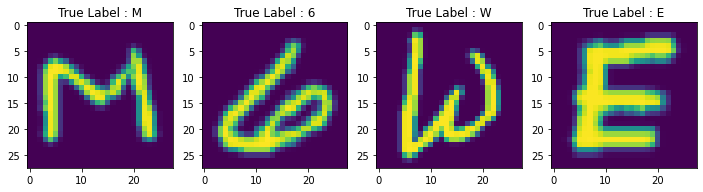

In [ ]:
# Displaying 4 random images from Testing Set:
i = randint(0,TestImages.shape[0])
plt.figure(figsize=(12,5))
for j in range(4):
  i = randint(0,TestImages.shape[0])
  plt.subplot(1,4,j+1)
  plt.imshow(TestImages[i])
  plt.title("True Label : "+ str(ReadableLabels(TestLabels[i])))
plt.show()

In [ ]:
#Flattening the 28x28 Train/Test Images to get 784 dimensional vector:
TrainImages=np.ravel(TrainImages).reshape(112800,-1)
TestImages=np.ravel(TestImages).reshape(18800,-1)

# Printing the shape after flattening the train/test images
print(TrainImages.shape)
print(TrainImages.shape)

(112800, 784)
(112800, 784)


In [ ]:
# Converting the numeric train labels to one hot encoding before training the Network.
encoder = LabelEncoder()
encoder.fit(TrainLabels)
encoded_Y = encoder.transform(TrainLabels)
y_onehot = np_utils.to_categorical(encoded_Y)

# Printing the numeric train labels and one hot encoded labels along with their shapes : 
print("Numeric train labels (0-46) : ", TrainLabels)
print("\nShape of numeric train labels : ", TrainLabels.shape)
print("\nOne hot encoded train labels : \n", y_onehot)
print("\nShape of one hot encoded train labels : ", y_onehot.shape)

Numeric train labels (0-46) :  [45 36 43 ... 23 31  8]

Shape of numeric train labels :  (112800,)

One hot encoded train labels : 
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Shape of one hot encoded train labels :  (112800, 47)


In [ ]:
# Adjust the various network parameters here >>

Input_dimen = 784                           # This is equal to flatten image size (28x28=784)
Number_of_hidden_layers = 2                 # This parameter should be atleast 1
Hidden_layer_neurons =  1000                # Defines the number of hidden neurons in each of the hidden layers
Hidden_activation_function = 'relu'         # Defines the activation function used in the hidden layers
Output_layer_neurons = 47                   # Here, we want 47 output neurons to classify the input as one of the 47 characters (labels)
Output_layer_activation = 'softmax'         # Defines the output activation function which is softmax for multiclass classification
loss_function = 'categorical_crossentropy'  # Loss function for multiclass classifcation
optimizer = 'adam'                          # Defines the optimizer
Batch_size = 256                            # Defines the batch size to use during training
Epochs = 60                                # The model will be trained for these number of epochs
Validation_split = 0.33                     # fraction by which the set has to divided into training

In [ ]:
# Function to create model by passing the required network parameters :

def NN_Model(id,nhl,hln,haf,oln,ola,lf,opt):
  model = Sequential()
  model.add(Dense(hln, input_dim = id, activation=haf, name='i/p-layer'))
  for i in range(nhl-1):
    model.add(Dense(hln, activation=haf))
  model.add(Dense(oln, activation=ola,name='o/p-layer'))
  model.compile(loss = lf, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# Creating a model with the entered parameters
Model = NN_Model(Input_dimen, Number_of_hidden_layers, Hidden_layer_neurons, Hidden_activation_function, Output_layer_neurons, Output_layer_activation, loss_function, optimizer)

#Training the model using the entered parameters
Details = Model.fit(TrainImages,y_onehot,validation_split= Validation_split, epochs=Epochs, batch_size=Batch_size)


Epoch 1/60
296/296 [==============================] - 9s 6ms/step - loss: 22.0127 - accuracy: 0.4236 - val_loss: 1.3830 - val_accuracy: 0.6444
Epoch 2/60
296/296 [==============================] - 1s 4ms/step - loss: 1.0682 - accuracy: 0.7069 - val_loss: 1.1042 - val_accuracy: 0.7051
Epoch 3/60
296/296 [==============================] - 1s 4ms/step - loss: 0.7607 - accuracy: 0.7719 - val_loss: 1.0350 - val_accuracy: 0.7306
Epoch 4/60
296/296 [==============================] - 1s 4ms/step - loss: 0.5945 - accuracy: 0.8102 - val_loss: 0.9720 - val_accuracy: 0.7461
Epoch 5/60
296/296 [==============================] - 1s 4ms/step - loss: 0.5132 - accuracy: 0.8328 - val_loss: 0.9471 - val_accuracy: 0.7589
Epoch 6/60
296/296 [==============================] - 1s 4ms/step - loss: 0.4711 - accuracy: 0.8449 - val_loss: 0.9469 - val_accuracy: 0.7557
Epoch 7/60
296/296 [==============================] - 1s 4ms/step - loss: 0.4282 - accuracy: 0.8558 - val_loss: 0.9768 - val_accuracy: 0.7588
Epoch

In [ ]:
# Enter the directory where you want the training results to be stored >>
files_dir = '/content/'

# Storing the history of training in a CSV file in the directory
hist_df = pd.DataFrame(Details.history)
hist_file_title = files_dir+'history_'+str(Epochs)+'_'+str(Batch_size)+'_'+str(Number_of_hidden_layers)+'_'+str(Hidden_layer_neurons)+'.csv'
with open(hist_file_title, mode='w') as f:
    hist_df.to_csv(f)

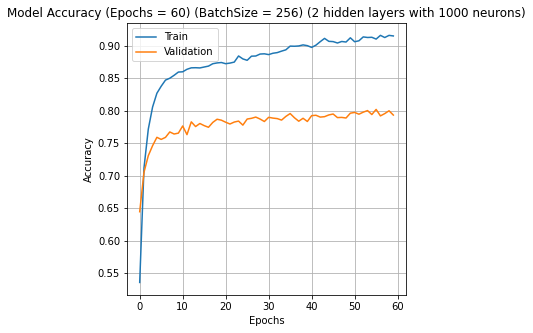

In [ ]:
# Plotting the Accuracy V/S Epoch graph of training
plt.figure(figsize=(5,5))
plt.plot(Details.history['accuracy'])
plt.plot(Details.history['val_accuracy'])
title = 'Model Accuracy'+' (Epochs = '+str(Epochs)+')'+' (BatchSize = '+str(Batch_size)+') ('+str(Number_of_hidden_layers)+' hidden layers with '+str(Hidden_layer_neurons)+' neurons)'
plt.title(title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
file_name = files_dir+'Accuracy_'+str(Epochs)+'_'+str(Batch_size)+'_'+str(Number_of_hidden_layers)+'_'+str(Hidden_layer_neurons)
plt.savefig(file_name)
plt.show()

In [ ]:
# Predicting the Test image labels and noting the testing accuracy
y_pred = np.argmax(Model.predict(TestImages), axis=-1)
test_accuracy = (18800 - np.count_nonzero(TestLabels-y_pred))*100/18800
print("Testing Accuracy : ",test_accuracy,'%')

Testing Accuracy :  79.43085106382979 %


In [ ]:
#5(d) Creating a confusion matrix to understand the most confused classes (characters).

ConfusionMatrix = np.zeros([47,47])
TrueLabels=TestLabels.reshape(-1,1)
PredictedLabels = y_pred.reshape(-1,1)
AllLabels=np.hstack((TrueLabels,PredictedLabels))
for i in range(TrueLabels.shape[0]):
  ConfusionMatrix[int(AllLabels[i,0])][int(AllLabels[i,1])]+=1

print("\nConfusion Matrix (check the saved CSV file for details): \n")
print(ConfusionMatrix)
conf_mat = pd.DataFrame(ConfusionMatrix)
conf_mat_file = files_dir+'ConfusionMatrix_'+str(Epochs)+'_'+str(Batch_size)+'_'+str(Number_of_hidden_layers)+'_'+str(Hidden_layer_neurons)+'.csv'
with open(conf_mat_file, mode='w') as f:
    conf_mat.to_csv(f)



Confusion Matrix (check the saved CSV file for details): 

[[292.   0.   0. ...   1.   1.   0.]
 [  0. 268.   1. ...   1.   0.   2.]
 [  0.   0. 333. ...   3.   0.   1.]
 ...
 [  1.   0.   0. ... 214.   0.   0.]
 [  0.   1.   0. ...   1. 348.   3.]
 [  0.   1.   0. ...   2.   4. 332.]]


Enter the true label of the test image you want to classify (between 0 to 46) :27


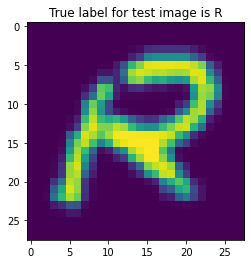


Label predicted by neural network :  ['R']


In [ ]:
# Classifying the test character entered by the user:
True_label=int(input("Enter the true label of the test image you want to classify (between 0 to 46) :"))

# Randomly selecting a Test image having true label = (label entered by user) from the set of Test images
temp_array = np.hstack((TrainImages,TrainLabels.reshape(112800,1))) 
np.random.shuffle(temp_array)
for Image in temp_array:
  if Image[784]==True_label:
    Test_Image=Image
    break
  else:
    continue

#Plotting the selected test image:
Imagetitle="True label for test image is "+ str(ReadableLabels(True_label))
plt.imshow(Test_Image[:-1].reshape(28,28))
plt.title(Imagetitle)
plt.show()

#Classifying the selected test image
Test_Image=Test_Image[0:784].reshape(-1,784)
Test_Image = np.asarray(Test_Image)
y_pred = np.argmax(Model.predict(Test_Image), axis=-1)
print("\nLabel predicted by neural network : ",ReadableLabels(y_pred))